In [2]:
import json
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import adjusted_rand_score
from sklearn.utils import resample

from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.impute import KNNImputer

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

import seaborn as sns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 50)

import warnings
warnings.filterwarnings('ignore')

#df = pd.read_csv('Ladle_slag_cleaned.csv',sep=',')
df = pd.read_csv('ladle_slags_countries.csv',sep=';',encoding='utf-8')

In [4]:
imputer = KNNImputer(n_neighbors=3)  # Use 3 nearest neighbors
cols = ['CaO', 'SiO2', 'Al2O3', 'Fe2O3', 'MgO']

maj = df[cols]
# Perform imputation
maj_imputed = pd.DataFrame(imputer.fit_transform(maj), columns=maj.columns)
maj_imputed['b5'] = (maj_imputed['CaO']+maj_imputed['MgO'])/(maj_imputed['SiO2']+maj_imputed['Al2O3'])


In [5]:
scaler = StandardScaler()
#Al_Si_scaled = scaler.fit_transform(maj_imputed[['SiO2','Al2O3']].dropna()) #'SiO2','Al2O3'
Ca_Fe_scaled = scaler.fit_transform(maj_imputed[['CaO','Fe2O3']].dropna()) #'CaO','Fe2O3',


# Define ranges for eps and min_samples
eps_values = np.arange(0.2, 0.6, 0.005)  # Test eps from 0.1 to 1.0 in steps of 0.1
min_samples_values = range(2, 8)  # Test min_samples from 2 to 9

# Store results
results = []

# Loop over eps and min_samples
for eps in eps_values:
    for min_samples in min_samples_values:
        # Fit DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        
        clusters = dbscan.fit_predict(Ca_Fe_scaled)

        # Evaluate clustering (only if more than 1 cluster is found)
        if len(set(clusters)) > 1:
            silhouette_avg = silhouette_score(Ca_Fe_scaled, clusters)
            db_index = davies_bouldin_score(Ca_Fe_scaled, clusters)
            n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)  # Exclude noise
            n_noise = list(clusters).count(-1)  # Count noise points
        else:
            silhouette_avg = -1  # Invalid score if only one cluster
            db_index = -1
            n_clusters = 0
            n_noise = len(clusters)

        # Store results
        results.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'silhouette_score': silhouette_avg,
            'davies_bouldin_index': db_index,
        })

# Convert results to a DataFrame
DBscan_results = pd.DataFrame(results)

# Display the results
#print(results_df)

# Find the best parameters based on Silhouette Score
best_result = DBscan_results.loc[DBscan_results['silhouette_score'].idxmax()]
print("\nBest Parameters:")
print(best_result)


Best Parameters:
eps                      0.395000
min_samples              2.000000
n_clusters               1.000000
n_noise                 11.000000
silhouette_score         0.657454
davies_bouldin_index     0.754563
Name: 234, dtype: float64


In [9]:
# Pivot the results for a heatmap
heatmap_data = DBscan_results.pivot(index='eps', columns='min_samples', values='silhouette_score')

# Plot the heatmap
#plt.figure(figsize=(18, 12))
#sns.heatmap(heatmap_data, annot=True, cmap='viridis', fmt=".2f")
#plt.title('Silhouette Score for Different eps and min_samples')
#plt.xlabel('min_samples')
#plt.ylabel('eps')
#plt.show()

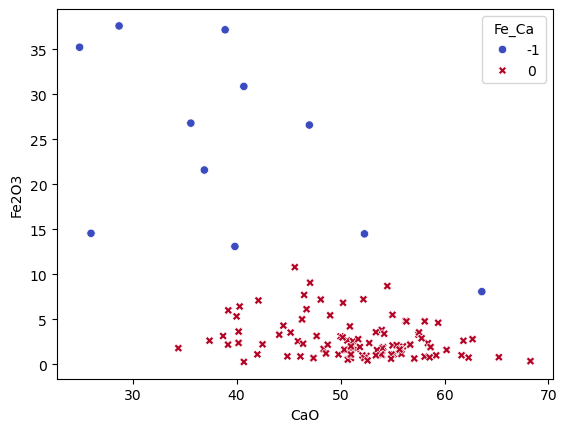

In [29]:
dbscan = DBSCAN(eps=0.395, min_samples=2)  # Adjust `eps` and `min_samples` as needed 
fe_ca_clusters= dbscan.fit_predict(Ca_Fe_scaled)
df['Fe_Ca'] = fe_ca_clusters
maj_imputed['Fe_Ca'] = fe_ca_clusters
#plt.scatter(data_scaled[:, 1], data_scaled[:, 0], c=df['Fe_Ca'], cmap='viridis', marker='o')
sns.scatterplot(data=maj_imputed, x='CaO', y='Fe2O3', palette='coolwarm', hue='Fe_Ca',style='Fe_Ca')
plt.xlabel('CaO')
plt.ylabel('Fe2O3')
#plt.title(f"CaO_Fe2O3 system: Silhouette score: 0.65")
#plt.savefig('../Figures/Ca_Fe_system',bbox_inches='tight')#,pad_inches=0.1
#plt.colorbar(label='Cluster')
plt.show()

In [19]:
#maj_imputed['Fe_Ca'].value_counts()

In [20]:
Al_Si_scaled = scaler.fit_transform(maj_imputed[['SiO2','Al2O3']].dropna()) #'SiO2','Al2O3'

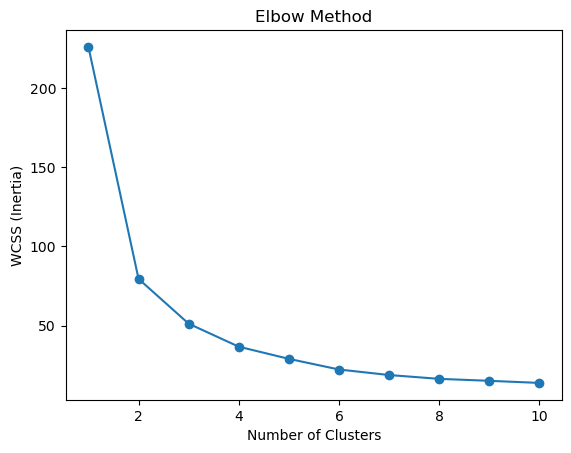

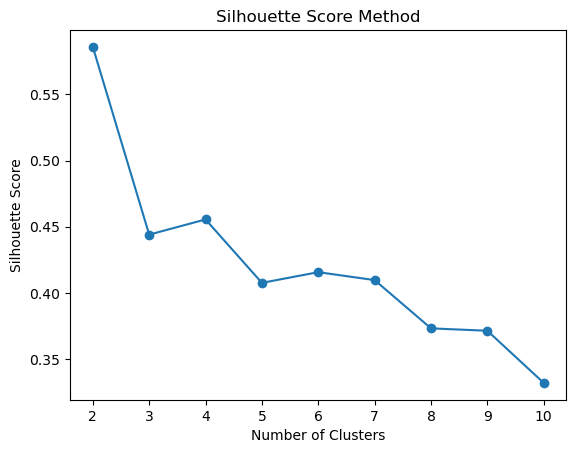

In [28]:
wcss = []
silhouette_scores = []
for k in range(1, 11):  # Test 1 to 10 clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(Al_Si_scaled)  # X_scaled is your scaled data
    wcss.append(kmeans.inertia_)
    if k > 1:
        cluster_labels = kmeans.fit_predict(Al_Si_scaled)  # X_scaled is your scaled data
        silhouette_avg = silhouette_score(Al_Si_scaled, cluster_labels)
        silhouette_scores.append(silhouette_avg)


# Plot the Elbow Curve
plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Inertia)')
plt.title('Elbow Method')
plt.show()

plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method')
plt.show()

#### -> Best option is k = 2 for parameters Al2O3 and SiO2

In [30]:
num_clusters = 2  # Choose the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans_clusters = kmeans.fit_predict(Al_Si_scaled)
#df['Al_Si_kmeans'] = kmeans_clusters
maj_imputed['Al_Si_kmeans'] = kmeans_clusters



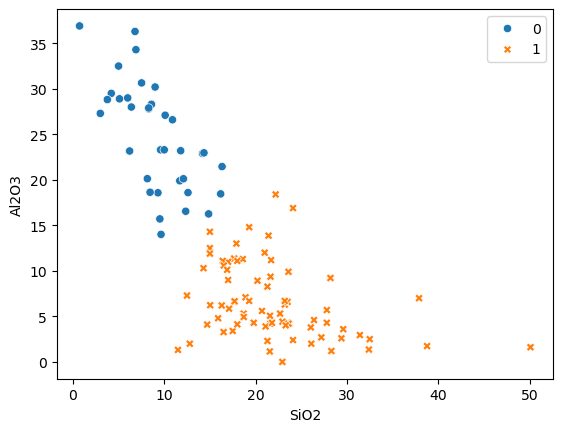

In [40]:
sns.scatterplot(data=maj_imputed, x='SiO2', y='Al2O3', hue='Al_Si_kmeans',style='Al_Si_kmeans')
plt.xlabel('SiO2')
plt.ylabel('Al2O3')

plt.legend()
plt.show()

In [36]:
maj_imputed['b5'] = round((maj_imputed['CaO'] + maj_imputed['MgO']) / (maj_imputed['SiO2'] + maj_imputed['Al2O3']),1)
maj_imputed['b3'] = round((maj_imputed['CaO']) / (maj_imputed['SiO2'] + maj_imputed['Al2O3']),1)

In [37]:
maj_imputed.head()

,CaO,SiO2,Al2O3,Fe2O3,MgO,b5,Fe_Ca,Al_Si_kmeans,b3
0,40.70,22.20,18.40,0.27,14.50,1.4,0,1,1.0
1,52.49,28.20,9.22,0.93,5.46,1.5,0,1,1.4
2,39.84,7.52,30.65,13.10,5.54,1.2,-1,0,1.0
3,26.00,6.80,36.30,14.56,9.10,0.8,-1,0,0.6
4,39.20,6.90,34.30,6.00,9.20,1.2,0,0,1.0


### Functions to train and test KNN model for each parameter combination 

In [55]:
def train_model(df, X_features,y):
    X_train, X_test, y_train, y_test = train_test_split(df[X_features], df[y], test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    print(f"Predicting {y} feature, from {X_features}:")
    best_cv = -np.inf
    best_cv_n = None
    cv = KFold(n_splits=5,shuffle=True,random_state=42)
    
    for k in range(1,15):        
        knn_reg = KNeighborsRegressor(n_neighbors=k,p=2)  # ,weights='distance'
        cv_score = cross_val_score(knn_reg,X_train_scaled, y_train,cv=cv, scoring='r2') 
        cv_mean = cv_score.mean()
        #print(f"k={k}, Mean R2 Score: {cv_mean:.3f}")
    
        # Perform cross-validation for RMSE
        cv_mse_scores = -cross_val_score(knn_reg, X_train_scaled, y_train, cv=cv, scoring='neg_mean_squared_error')
        cv_rmse_scores = np.sqrt(cv_mse_scores)  # Convert MSE to RMSE
        cv_rmse_mean = cv_rmse_scores.mean()
        cv_rmse_std = cv_rmse_scores.std()
        #print(f"k={k}, Mean R2 Score: {cv_mean:.3f}, Mean RMSE: {cv_rmse_mean:.3f},\t Std RMSE: {cv_rmse_std:.3f}\t ") #CV R2 scores: {cv_score}
        
        
        # Perform cross-validation
        if cv_mean>best_cv:
            best_cv = cv_mean
            best_cv_n = k

    print(f"Best Cross-Validation R2 Scores: {best_cv.round(3)}")
    print(f"Best CV n: {best_cv_n}")
    return best_cv, best_cv_n, cv_rmse_mean, cv_rmse_std, X_train_scaled, X_test_scaled, y_train,y_test, scaler


def test_model(X_train_scaled,X_test_scaled,y_train,y_test ,k:int,p:int, y_prediction:str):
    print(f"Testing prediction of {y_prediction} for {k} neighbours")
    final_model = KNeighborsRegressor(n_neighbors=k,p=2)  # ,weights='distance'
    final_model.fit(X_train_scaled, y_train)
    y_pred = final_model.predict(X_test_scaled)
    mse = mean_squared_error(y_test,y_pred)
    rmse = np.sqrt(mse)
    errors = y_test - y_pred  # per-sample errors
    error_std = errors.std()
    r2 = r2_score(y_test,y_pred)
    
    print(f"Test Set R2 Score: {r2:.3f}")
    print(f"Test Set RMSE: {rmse:.3f}")
    #print(f"Error std: {error_std}")
    return r2,k,rmse,final_model


In [58]:
### Note: Always use .transform() when scaling a new sample to fit with the trained data.

In [103]:
def predict_with_model(model,scaler,sample):
    # [Ca_model,Al_model,Si_model,Fe_model]
    scaled_sample = scaler.transform(sample)
    y_pred = model.predict(scaled_sample)
    return y_pred[0]


def predict_all_parameters(models:dict,scaler:dict,sample): # Sample in np.array format
    result = {}
    if isinstance(sample,str):
        print("Is file comma-separated or colon-separated?")
        delimiter = input("Specify (, or ;): ")
        sample = pd.read_csv(sample,sep=delimiter,encoding='utf-8').values #np.array
        
    for key,model in models.items():
        result[key] = predict_with_model(model,scaler[key],sample)
    return pd.DataFrame(data=result.values(),index=result.keys()).T

    

### Aluminium model

In [56]:
al_input = ['b5','Fe_Ca','Al_Si_kmeans']
al_cv_r2, al_cv_n, al_cv_rmse_mean, al_cv_rmse_std, X_train_scaled, X_test_scaled, al_y_train, al_y_test,al_scaler = train_model(maj_imputed.round(1),
                                                            al_input,
                                                          ['Al2O3'])
print()
al_test, al_test_n, al_test_rmse,al_model = test_model(X_train_scaled, X_test_scaled,al_y_train,al_y_test, 13,2,'Al2O3')

Predicting ['Al2O3'] feature, from ['b5', 'Fe_Ca', 'Al_Si_kmeans']:
Best Cross-Validation R2 Scores: 0.742
Best CV n: 13

Testing prediction of Al2O3 for 13 neighbours
Test Set R2 Score: 0.709
Test Set RMSE: 4.957


In [59]:
si_input = ['b5','Fe_Ca','Al_Si_kmeans']#['b5','SiO2_mean']
si_cv_r2, si_cv_n, si_cv_rmse_mean, si_cv_rmse_std, X_train_scaled, X_test_scaled, si_y_train, si_y_test,si_scaler = train_model(maj_imputed.round(1),
                                                            si_input,
                                                          ['SiO2'])
print()
si_test, si_test_n, si_test_rmse,si_model = test_model(X_train_scaled, X_test_scaled,si_y_train,si_y_test, 8,2, 'SiO2')

Predicting ['SiO2'] feature, from ['b5', 'Fe_Ca', 'Al_Si_kmeans']:
Best Cross-Validation R2 Scores: 0.691
Best CV n: 8

Testing prediction of SiO2 for 8 neighbours
Test Set R2 Score: 0.646
Test Set RMSE: 4.159


In [60]:
ca_input = ['b3','Fe_Ca','Al_Si_kmeans']#['b_CaSiAl','Fe2O3_mean','CaO_mean']#
ca_cv_r2, ca_cv_n, ca_cv_rmse_mean, ca_cv_rmse_std, X_train_scaled, X_test_scaled, ca_y_train, ca_y_test,ca_scaler = train_model(maj_imputed.round(1),
                                                            ca_input,
                                                          ['CaO'])
print()
ca_test, ca_test_n, ca_test_rmse,ca_model = test_model(X_train_scaled, X_test_scaled,ca_y_train,ca_y_test, 3,2, 'CaO')

Predicting ['CaO'] feature, from ['b3', 'Fe_Ca', 'Al_Si_kmeans']:
Best Cross-Validation R2 Scores: 0.545
Best CV n: 3

Testing prediction of CaO for 3 neighbours
Test Set R2 Score: 0.563
Test Set RMSE: 5.020


In [61]:
fe_input = ['b5','Fe_Ca','Al_Si_kmeans']#['b_CaSiAl','CaO_mean','SiO2_mean']#
fe_cv_r2, fe_cv_n, fe_cv_rmse_mean, fe_cv_rmse_std, X_train_scaled, X_test_scaled, fe_y_train, fe_y_test,fe_scaler = train_model(maj_imputed.round(1),
                                                            fe_input,
                                                          ['Fe2O3'])
print()
fe_test, fe_test_n, fe_test_rmse,fe_model = test_model(X_train_scaled, X_test_scaled,fe_y_train,fe_y_test, 7,2, 'Fe2O3')

Predicting ['Fe2O3'] feature, from ['b5', 'Fe_Ca', 'Al_Si_kmeans']:
Best Cross-Validation R2 Scores: 0.521
Best CV n: 7

Testing prediction of Fe2O3 for 7 neighbours
Test Set R2 Score: 0.752
Test Set RMSE: 4.628


In [108]:
tryout = predict_with_model(al_model,al_scaler,np.array([[2.6,0,0]]))
model_dict = {'CaO':ca_model,'SiO2':si_model,'Al2O3':al_model,'Fe2O3':fe_model}
scaler_dict = {'CaO':ca_scaler,'SiO2':si_scaler,'Al2O3':al_scaler,'Fe2O3':fe_scaler}

tryout = predict_all_parameters(model_dict,scaler_dict,np.array([[2.6,0,0]]),)

In [109]:
tryout

,CaO,SiO2,Al2O3,Fe2O3
0,59.833333,8.8875,21.461538,2.128571


In [110]:
from joblib import dump

In [111]:
dump(ca_model, 'ca_model.joblib')  # Saves the model
dump(ca_scaler, 'ca_scaler.joblib') # Save scaler  
dump(si_model, 'si_model.joblib')  
dump(si_scaler, 'si_scaler.joblib')  
dump(al_model, 'al_model.joblib')  
dump(al_scaler, 'al_scaler.joblib')  
dump(fe_model, 'fe_model.joblib')  
dump(fe_scaler, 'fe_scaler.joblib')  

['fe_scaler.joblib']